In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Music Genre Classification

Covered points (in no particular order):

*   Feature Extraction
*   Data Encoding & Train-Test Splitting
*   Machine learning models : SVM , KNN
*   Two feature selection methods : SelectKBest, Random Forest
*   Implementation of third custom random feature selection method


#Feature Extraction

In [ ]:
import librosa
import IPython 
import numpy
import os
import pandas as pd 
# This function allows the extract these features from each signal (we will use it to extract features from all the audio files)
def get_feature_vector(data, sr):
    # Chroma 
    chromagram = numpy.array(librosa.feature.chroma_stft(y=data, sr=sr)).flatten()
    chroma_stft_mean = chromagram.mean()
    chroma_stft_var = chromagram.var()
    #  root-mean-square (RMS)
    rms = librosa.feature.rms(y=data)
    rms_mean = rms.mean()
    rms_var = rms.mean()
    # Spectal centroid
    spectral_centroids = numpy.array(librosa.feature.spectral_centroid(y=data, sr=sr)).flatten()
    spectral_centroid_mean = spectral_centroids.mean()
    spectral_centroid_var = spectral_centroids.var()
    # Spectal bandwidth
    spectral_bandwidth = numpy.array(librosa.feature.spectral_bandwidth(y=data, sr=sr)).flatten()
    spectral_bandwidth_mean = spectral_bandwidth.mean()
    spectral_bandwidth_var = spectral_bandwidth.var()
    # Rolloff
    rollof = numpy.array(librosa.feature.spectral_rolloff(y=data, sr=sr)).flatten()
    rollof_mean = rollof.mean()
    rollof_var = rollof.var()
    # Zero Crossing rate
    zero_crossing_rate = numpy.array(librosa.feature.zero_crossing_rate(y=data)).flatten()
    zero_crossing_rate_mean = zero_crossing_rate.mean()
    zero_crossing_rate_var = zero_crossing_rate.var()
    # Harmony
    harmony = numpy.array(librosa.feature.tempogram(y=data, sr=sr)).flatten()
    harmony_mean = harmony.mean()
    harmony_var = harmony.var()
    # Percussive signals
    perceptr = numpy.array(librosa.effects.percussive(y=data))
    perceptr_mean = perceptr.mean()
    perceptr_var = perceptr.var()
    # Tempo
    tempo = librosa.beat.tempo(y=data, sr=sr)[0]
    # Mel-Frequency Cepstral Coefficients (MFCC): 
    melspectrogram = numpy.array(librosa.feature.melspectrogram(y=data, sr=sr)).flatten()
    melspectrogram_mean = melspectrogram.mean()
    melspectrogram_var = melspectrogram.var()
    mfcc = librosa.feature.mfcc(y=data, sr=sr)
    mfcc_vals = []
    for i, m in enumerate(mfcc):
        mfcc_vals.append(mfcc[i].mean())
        mfcc_vals.append(mfcc[i].var())
    features = numpy.array((chroma_stft_mean, chroma_stft_var, rms_mean, rms_var, spectral_centroid_mean, spectral_centroid_var, 
                             spectral_bandwidth_mean, spectral_bandwidth_var, rollof_mean, rollof_var, zero_crossing_rate_mean,
                              zero_crossing_rate_var, harmony_mean, harmony_var, perceptr_mean, perceptr_var, tempo, melspectrogram_mean, melspectrogram_var))
    features = numpy.concatenate((features, mfcc_vals))
    return features

In [ ]:
# collect features for all genres in the GTZAN dataset
genres_path = "/content/drive/MyDrive/Music Classification/genres_original/"
genres = [name for name in os.listdir(genres_path) if os.path.isdir(os.path.join(genres_path, name))]

df = None
i = 0
for genre in genres:
    for file in [os.path.join(genres_path + genre, f) for f in os.listdir(genres_path + genre) if os.path.isfile(os.path.join(genres_path + genre, f))]:
        if i % 10 == 0:
            print(f"processing file {i}")
        try:
            data, sr = librosa.load(file)
            name = os.path.basename(file)
            feature_vector = get_feature_vector(data, sr)
            if df is None:
                cols = ["file", "name"] + ["data"+str(i) for i in range(len(list(feature_vector)))]
                df = pd.DataFrame(columns = cols)
            df.loc[i] = [name, genre] + list(feature_vector)
            i = i + 1
        except Exception as e: print(e)
# saving all the collected features to a csv file , so that we won't need to re-extract all the features each time , and we can just start from this csv file.
df.to_csv('extracted-features.csv')  

#Feature Selection

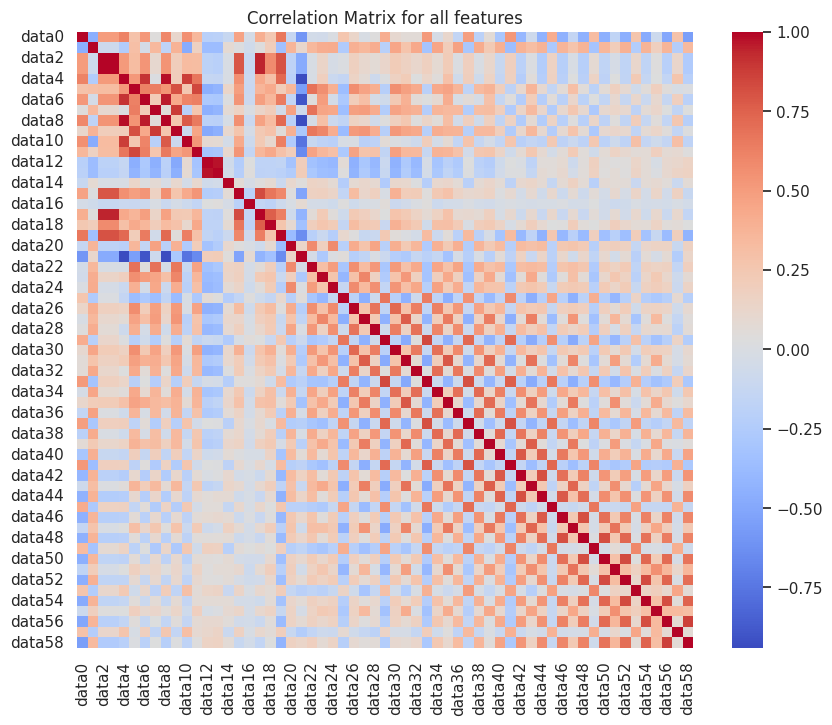

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file containing the extracted features
df = pd.read_csv('extracted-features.csv')

# Specify the feature groups
feature_groups = [['data' + str(i) for i in range(0, 59)]]

# Create a correlation matrix for each feature group
for group in feature_groups:
    # Filter the dataframe to include only the specified features
    group_df = df[group]
    # Compute the correlation matrix
    corr = group_df.corr()
    # Plot the correlation matrix using Seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap='coolwarm', annot=False, square=True)
    plt.title('Correlation Matrix for all features'.format(group))
    plt.show()

<ipython-input-48-89507d8d3115>:20: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


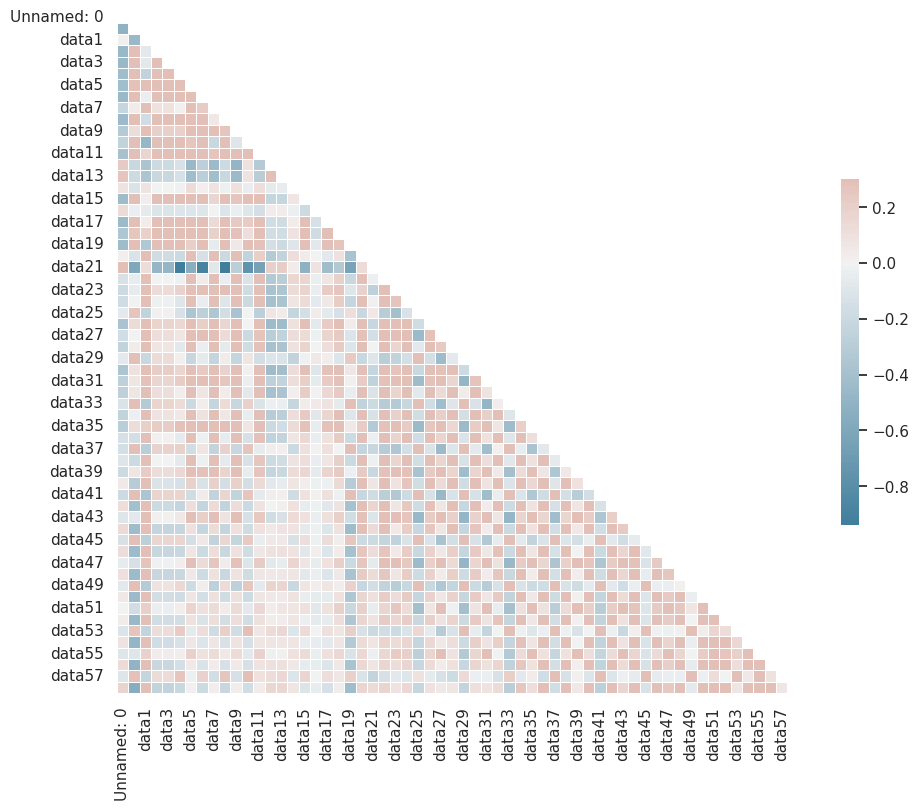

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data=pd.read_csv('extracted-features.csv')
# Create a dictionary that maps the column names to the feature names
col_to_feature = {}
for i, feature_group in enumerate(feature_groups):
    for j, feature_name in enumerate(feature_group):
        if len(feature_group) == 1:
            col_to_feature[f"data{i}"] = feature_name
        else:
            col_to_feature[f"data{i}_{j}"] = feature_name

# Rename the columns of the DataFrame with the feature names
data = data.rename(columns=col_to_feature)

# Compute the correlation matrix
corr_matrix = data.corr()

# Generate the correlation plot using Seaborn
sns.set(style="white")
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

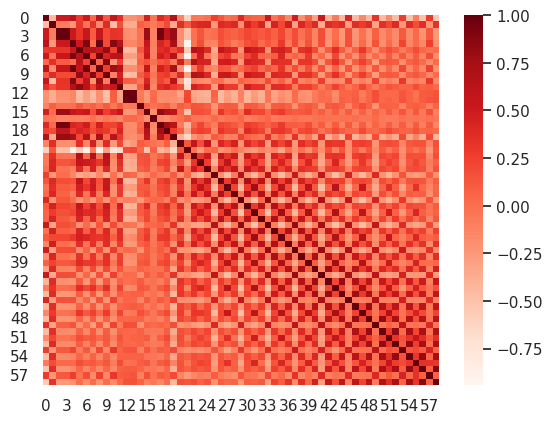

    Feature      Score
15       15  66.145727
18       18  52.013031
13       13  50.456207
5         5  49.016455
17       17  41.603649
9         9  41.225220
8         8  40.986010
6         6  40.548274
0         0  40.292490
11       11  39.068699


<ipython-input-49-487631b71b08>:41: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X, y)


    Feature  Importance
0         0    0.045431
15       15    0.037971
25       25    0.030374
6         6    0.029175
18       18    0.028483
1         1    0.027713
3         3    0.024560
5         5    0.023692
8         8    0.023217
28       28    0.022572
Best columns selected using SelectKBest:
[15 18 13  5 17  9  8  6  0 11]

Best columns selected using Feature Importance:
[ 0 15 25  6 18  1  3  5  8 28]


[0, 15, 25, 6, 18, 1, 3, 5, 8, 28]

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier

# Load data from csv file
df = pd.read_csv('extracted-features.csv')

# Split the data into features and target variable
X = df.iloc[:,3:]
y = df['name']
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X))

#Encoding the labels ("genres") - converting the string values to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
y = pd.DataFrame(le.transform(y))

# Correlation analysis
corr = X.corr()
sns.heatmap(corr, cmap=plt.cm.Reds)
plt.show()

# SelectKBest feature selection using chi-squared test
best_features = SelectKBest(score_func=chi2, k=10)
fit = best_features.fit(X, y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature', 'Score']
print(feature_scores.nlargest(10, 'Score'))

# Feature Importance: This method ranks the importance of each feature. Features with high importance scores are selected.
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X, y)
importances = rf.feature_importances_
selected_features = pd.DataFrame({'Feature':X.columns, 'Importance':importances})
selected_features = selected_features.sort_values(by='Importance', ascending=False).head(10)
print(selected_features)

# Print the names of the best columns selected
print("Best columns selected using SelectKBest:")
print(feature_scores.nlargest(10, 'Score')['Feature'].values)
print("\nBest columns selected using Feature Importance:")
print(selected_features['Feature'].values)
list(selected_features['Feature'].values)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('extracted-features.csv')
#Selected features:
sfeatures=[]
for k in list(selected_features['Feature'].values):
    sfeatures.append("data"+str(k))
X=df
#Encoding the labels ("genres") which means , conversting the string values to integers, so that it will be easier to manipulate with computers
from sklearn.preprocessing import LabelEncoder
labels_df = df['name']
le = LabelEncoder()
le.fit(labels_df)
labels_df = le.transform(labels_df)

#Normalising the data, This can be useful for some machine learning algorithms that require the input data to be on the same scale.
from sklearn import preprocessing
print(selected_features)
X = X[sfeatures]
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,labels_df, test_size=0.2, random_state=42)

    Feature  Importance
0         0    0.045431
15       15    0.037971
25       25    0.030374
6         6    0.029175
18       18    0.028483
1         1    0.027713
3         3    0.024560
5         5    0.023692
8         8    0.023217
28       28    0.022572


#Experimenting Machine Learning Algorithm (Feature Selection)


Test with features selected using SelectKBest

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score

#modelTest that takes a machine learning model as input,
#fits the model to the training data and then uses the trained model
#to make predictions on the test data. The function then calculates and
#returns the accuracy score
def modelTest(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    train_accuracy = accuracy_score(y_train, train_preds)
    test_accuracy = accuracy_score(y_test, test_preds)
    return train_accuracy, test_accuracy


# This code defines a grid search using a combination of hyperparameters for a support vector machine
# (SVM) model. The hyperparameters being explored include the regularization parameter C,
# the kernel function (linear, poly, or rbf), the degree of the polynomial kernel
# (for poly kernel only), and whether to use probability estimates.

Cs = [0.01,0.1,0.2,0.4,0.8,1,2,4,10,20,40]
kernels = ['linear', 'poly', 'poly', 'rbf']
degrees = [3, 3, 5, 3]
a_results = [[], [], [], []]

for i, cc in enumerate(Cs):
    print('C=' + str(cc))
    for j in range(4):
        svm = SVC(kernel=kernels[j], degree=degrees[j], gamma='scale', shrinking=True, C=cc, probability=True, decision_function_shape="ovo")
        
        # add cross-validation with 5 folds
        cv_scores = cross_val_score(svm, X_train, y_train, cv=5)
        print("Cross-validation scores: {}".format(cv_scores))
        print("Average cross-validation score: {:.2f}".format(cv_scores.mean()))
        
        train_a, test_a = modelTest(svm, X_train, y_train, X_test, y_test)
        print("Train accuracy: {:.2f}".format(train_a))
        print("Test accuracy: {:.2f}".format(test_a))
        
        a_results[j].append(test_a)

a_linear, a_poly3, a_poly5, a_rbf = a_results


C=0.01
Cross-validation scores: [0.10625    0.10625    0.1125     0.1125     0.11320755]
Average cross-validation score: 0.11
Train accuracy: 0.11
Test accuracy: 0.06
Cross-validation scores: [0.4625     0.375      0.475      0.4125     0.47798742]
Average cross-validation score: 0.44
Train accuracy: 0.47
Test accuracy: 0.42
Cross-validation scores: [0.6        0.50625    0.53125    0.54375    0.55345912]
Average cross-validation score: 0.55
Train accuracy: 0.61
Test accuracy: 0.52
Cross-validation scores: [0.10625    0.10625    0.1125     0.1125     0.11320755]
Average cross-validation score: 0.11
Train accuracy: 0.11
Test accuracy: 0.06
C=0.1
Cross-validation scores: [0.33125    0.325      0.3375     0.35625    0.33333333]
Average cross-validation score: 0.34
Train accuracy: 0.37
Test accuracy: 0.31
Cross-validation scores: [0.6125     0.50625    0.56875    0.53125    0.55345912]
Average cross-validation score: 0.55
Train accuracy: 0.61
Test accuracy: 0.49
Cross-validation scores: [0

<ipython-input-25-46c7483e00a3>:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(Cs, a_linear, 'o-', markersize=10, linestyle='None', label='Linear kernel')
<ipython-input-25-46c7483e00a3>:9: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(Cs, a_poly3, 's-', markersize=10, linestyle='None', label='Poly 3-degree kernel')
<ipython-input-25-46c7483e00a3>:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "d-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(Cs, a_poly5, 'd-', markersize=10, linestyle='None', label='Poly 5-degree kernel')
<ipython-input-25-46c7483e00a3>:11: UserWarning: linestyle is redundantly defined by the 'linestyle' k

IndexError: ignored

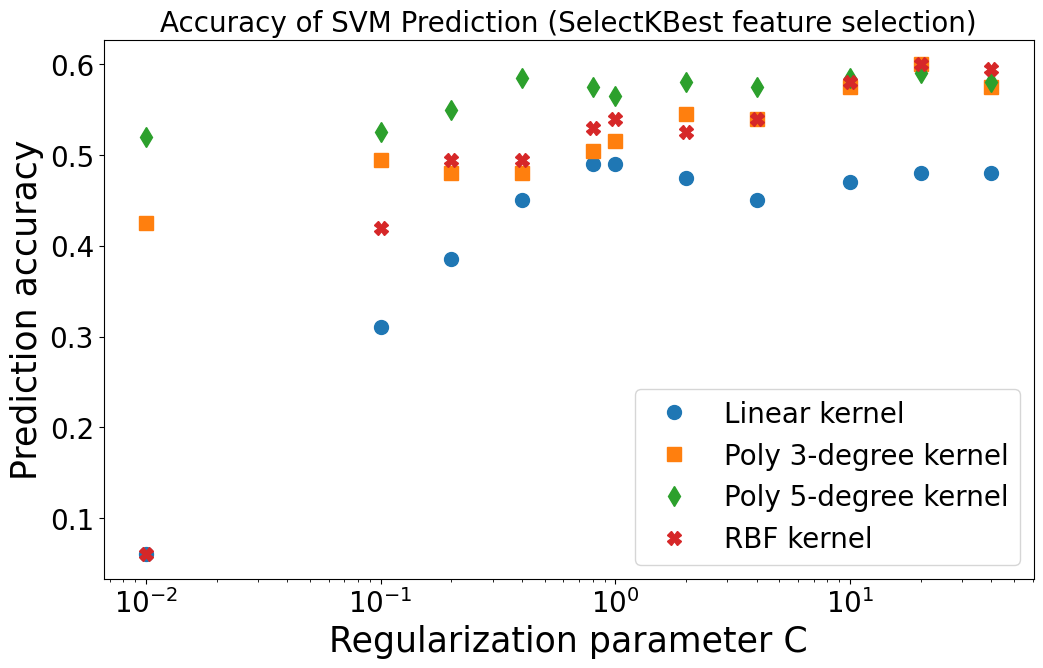

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#This code uses the matplotlib library to create a plot of the accuracy of SVM prediction
#for different regularization parameters and kernel types. 
def plotSVM(a_linear, a_poly3, a_poly5, a_rbf):
    plt.figure(figsize=(12, 7))
    plt.semilogx(Cs, a_linear, 'o-', markersize=10, linestyle='None', label='Linear kernel')
    plt.semilogx(Cs, a_poly3, 's-', markersize=10, linestyle='None', label='Poly 3-degree kernel')
    plt.semilogx(Cs, a_poly5, 'd-', markersize=10, linestyle='None', label='Poly 5-degree kernel')
    plt.semilogx(Cs, a_rbf, 'X-', markersize=10, linestyle='None', label='RBF kernel')

    plt.title("Accuracy of SVM Prediction (SelectKBest feature selection)", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("Regularization parameter C", fontsize=25)
    plt.ylabel("Prediction accuracy", fontsize=25)

    plt.legend(bbox_to_anchor=(1.0, 0.0), loc='lower right', fontsize=20)

    max_acc_idx = np.argmax(a_linear + a_poly3 + a_poly5 + a_rbf)
    max_acc = max(a_linear + a_poly3 + a_poly5 + a_rbf)
    max_acc_C = Cs[max_acc_idx]

    plt.text(max_acc_C, max_acc, f'{max_acc:.2f}', fontsize=15, ha='center', va='bottom')

plotSVM(a_linear, a_poly3, a_poly5, a_rbf)


<ipython-input-51-5d4466a41d25>:30: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(k_values, accuracies[:, i, j], 'o-', markersize=10, linestyle='None', mec='None', label=f"{weight} + {metric}")


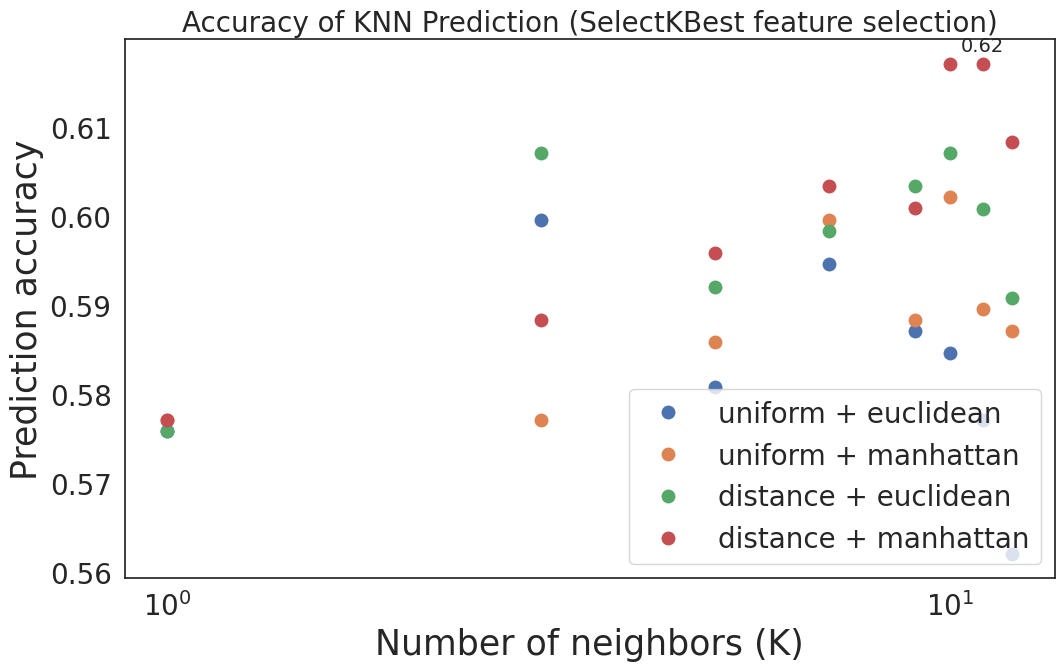

In [ ]:
from sklearn.model_selection import cross_val_score

# Define a range of parameter values to try
k_values = [1, 3, 5, 7, 9, 10, 11, 12]
weights = ['uniform', 'distance']
metrics = ['euclidean', 'manhattan']

# Initialize empty arrays to store accuracy scores
accuracies = np.zeros((len(k_values), len(weights), len(metrics)))

# Loop over parameter values and fit KNN model with each combination
for i, k in enumerate(k_values):
    for j, weight in enumerate(weights):
        for kk, metric in enumerate(metrics):
            knn = KNeighborsClassifier(n_neighbors=k, weights=weight, metric=metric)
            
            # Perform cross-validation with 5 folds and get the average accuracy score
            accuracy_scores = cross_val_score(knn, X_train, y_train, cv=5)
            accuracy = np.mean(accuracy_scores)

            # Store accuracy score for this combination of parameters
            accuracies[i, j, kk] = accuracy


# Plot accuracy for different parameter values
plt.figure(figsize=(12, 7))

for i, weight in enumerate(weights):
    for j, metric in enumerate(metrics):
        plt.semilogx(k_values, accuracies[:, i, j], 'o-', markersize=10, linestyle='None', mec='None', label=f"{weight} + {metric}")

# Add label to the highest datapoint on the Y axis
max_accuracy = np.max(accuracies)
max_k, max_weight_index, max_metric_index = np.unravel_index(np.argmax(accuracies), accuracies.shape)
max_accuracy_index = np.argmax(accuracies[:, max_weight_index, max_metric_index])
plt.text(k_values[max_accuracy_index], max_accuracy+0.001, f"{max_accuracy:.2f}", fontsize=14, ha='center', va='bottom')

plt.title("Accuracy of KNN Prediction (SelectKBest feature selection)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Number of neighbors (K)", fontsize=25)
plt.ylabel("Prediction accuracy", fontsize=25)

plt.legend(loc='lower right', fontsize=20)
plt.show()


Test with features selected using Random Forest

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('extracted-features.csv')
#Selected features:
sfeatures=[]
for k in list(feature_scores.nlargest(10, 'Score')['Feature'].values):
    sfeatures.append("data"+str(k))
X=df
#Encoding the labels ("genres") which means , conversting the string values to integers, so that it will be easier to manipulate with computers
from sklearn.preprocessing import LabelEncoder
labels_df = df['name']
le = LabelEncoder()
le.fit(labels_df)
labels_df = le.transform(labels_df)

#Normalising the data, This can be useful for some machine learning algorithms that require the input data to be on the same scale.
from sklearn import preprocessing
print(selected_features)
X = X[sfeatures]
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,labels_df, test_size=0.1, random_state=42)

    Feature  Importance
0         0    0.045431
15       15    0.037971
25       25    0.030374
6         6    0.029175
18       18    0.028483
1         1    0.027713
3         3    0.024560
5         5    0.023692
8         8    0.023217
28       28    0.022572


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score

#modelTest that takes a machine learning model as input,
#fits the model to the training data and then uses the trained model
#to make predictions on the test data. The function then calculates and
#returns the accuracy score
def modelTest(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    train_accuracy = accuracy_score(y_train, train_preds)
    test_accuracy = accuracy_score(y_test, test_preds)
    return train_accuracy, test_accuracy


# This code defines a grid search using a combination of hyperparameters for a support vector machine
# (SVM) model. The hyperparameters being explored include the regularization parameter C,
# the kernel function (linear, poly, or rbf), the degree of the polynomial kernel
# (for poly kernel only), and whether to use probability estimates.

Cs = [0.01,0.1,0.2,0.4,0.8,1,2,4,10,20,40]
kernels = ['linear', 'poly', 'poly', 'rbf']
degrees = [3, 3, 5, 3]
a_results = [[], [], [], []]

for i, cc in enumerate(Cs):
    print('C=' + str(cc))
    for j in range(4):
        svm = SVC(kernel=kernels[j], degree=degrees[j], gamma='scale', shrinking=True, C=cc, probability=True, decision_function_shape="ovo")
        
        # add cross-validation with 5 folds
        cv_scores = cross_val_score(svm, X_train, y_train, cv=5)
        print("Cross-validation scores: {}".format(cv_scores))
        print("Average cross-validation score: {:.2f}".format(cv_scores.mean()))
        
        train_a, test_a = modelTest(svm, X_train, y_train, X_test, y_test)
        print("Train accuracy: {:.2f}".format(train_a))
        print("Test accuracy: {:.2f}".format(test_a))
        
        a_results[j].append(test_a)

a_linear, a_poly3, a_poly5, a_rbf = a_results


C=0.01
Cross-validation scores: [0.18888889 0.10555556 0.10555556 0.10555556 0.20670391]
Average cross-validation score: 0.14
Train accuracy: 0.11
Test accuracy: 0.05
Cross-validation scores: [0.37777778 0.36666667 0.38888889 0.42777778 0.41340782]
Average cross-validation score: 0.39
Train accuracy: 0.42
Test accuracy: 0.32
Cross-validation scores: [0.41666667 0.38333333 0.45555556 0.42777778 0.45810056]
Average cross-validation score: 0.43
Train accuracy: 0.47
Test accuracy: 0.28
Cross-validation scores: [0.19444444 0.10555556 0.10555556 0.10555556 0.20111732]
Average cross-validation score: 0.14
Train accuracy: 0.12
Test accuracy: 0.05
C=0.1
Cross-validation scores: [0.40555556 0.43333333 0.37777778 0.42222222 0.41340782]
Average cross-validation score: 0.41
Train accuracy: 0.43
Test accuracy: 0.25
Cross-validation scores: [0.50555556 0.48333333 0.44444444 0.51666667 0.48044693]
Average cross-validation score: 0.49
Train accuracy: 0.53
Test accuracy: 0.36
Cross-validation scores: [0

<ipython-input-29-a78251121dea>:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(Cs, a_linear, 'o-', markersize=10, linestyle='None', label='Linear kernel')
<ipython-input-29-a78251121dea>:9: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(Cs, a_poly3, 's-', markersize=10, linestyle='None', label='Poly 3-degree kernel')
<ipython-input-29-a78251121dea>:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "d-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(Cs, a_poly5, 'd-', markersize=10, linestyle='None', label='Poly 5-degree kernel')
<ipython-input-29-a78251121dea>:11: UserWarning: linestyle is redundantly defined by the 'linestyle' k

IndexError: ignored

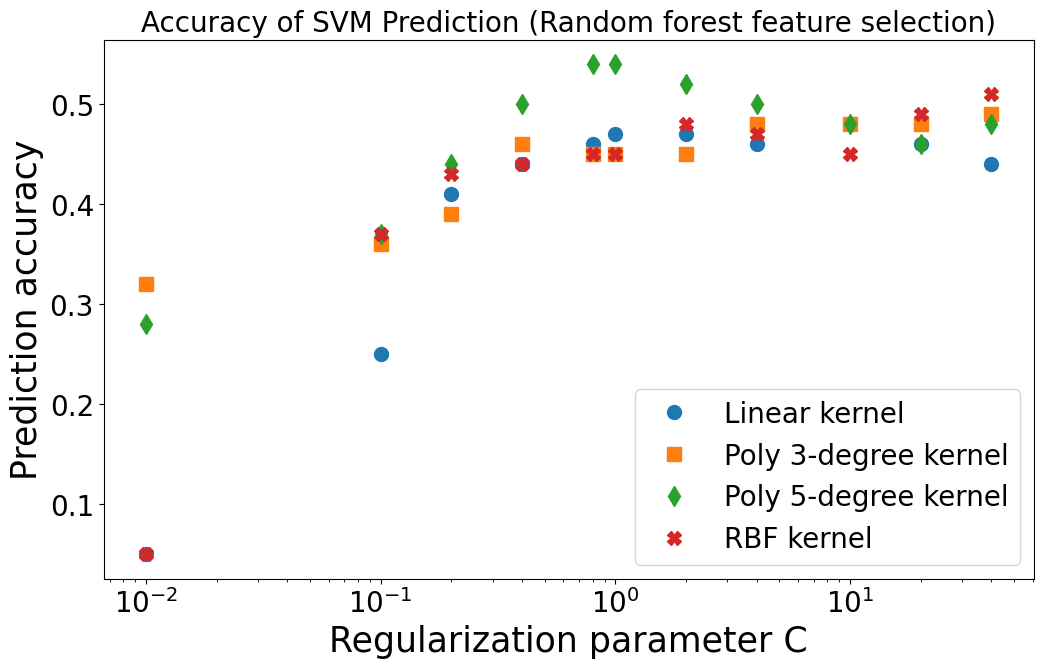

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#This code uses the matplotlib library to create a plot of the accuracy of SVM prediction
#for different regularization parameters and kernel types. 
def plotSVM(a_linear, a_poly3, a_poly5, a_rbf):
    plt.figure(figsize=(12, 7))
    plt.semilogx(Cs, a_linear, 'o-', markersize=10, linestyle='None', label='Linear kernel')
    plt.semilogx(Cs, a_poly3, 's-', markersize=10, linestyle='None', label='Poly 3-degree kernel')
    plt.semilogx(Cs, a_poly5, 'd-', markersize=10, linestyle='None', label='Poly 5-degree kernel')
    plt.semilogx(Cs, a_rbf, 'X-', markersize=10, linestyle='None', label='RBF kernel')

    plt.title("Accuracy of SVM Prediction (Random forest feature selection)", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("Regularization parameter C", fontsize=25)
    plt.ylabel("Prediction accuracy", fontsize=25)

    plt.legend(bbox_to_anchor=(1.0, 0.0), loc='lower right', fontsize=20)

    max_acc_idx = np.argmax(a_linear + a_poly3 + a_poly5 + a_rbf)
    max_acc = max(a_linear + a_poly3 + a_poly5 + a_rbf)
    max_acc_C = Cs[max_acc_idx]

    plt.text(max_acc_C, max_acc, f'{max_acc:.2f}', fontsize=15, ha='center', va='bottom')

plotSVM(a_linear, a_poly3, a_poly5, a_rbf)

<ipython-input-55-0be9e50b98b0>:30: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(k_values, accuracies[:, i, j], 'o-', markersize=10, linestyle='None', mec='None', label=f"{weight} + {metric}")


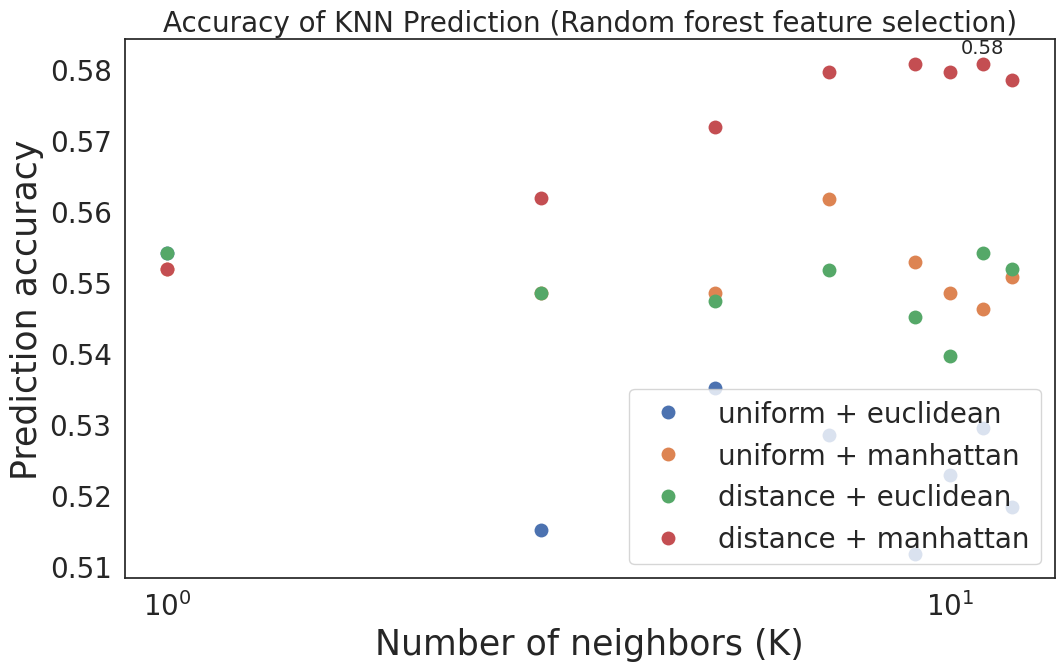

In [ ]:
from sklearn.model_selection import cross_val_score

# Define a range of parameter values to try
k_values = [1, 3, 5, 7, 9, 10, 11, 12]
weights = ['uniform', 'distance']
metrics = ['euclidean', 'manhattan']

# Initialize empty arrays to store accuracy scores
accuracies = np.zeros((len(k_values), len(weights), len(metrics)))

# Loop over parameter values and fit KNN model with each combination
for i, k in enumerate(k_values):
    for j, weight in enumerate(weights):
        for kk, metric in enumerate(metrics):
            knn = KNeighborsClassifier(n_neighbors=k, weights=weight, metric=metric)
            
            # Perform cross-validation with 5 folds and get the average accuracy score
            accuracy_scores = cross_val_score(knn, X_train, y_train, cv=5)
            accuracy = np.mean(accuracy_scores)

            # Store accuracy score for this combination of parameters
            accuracies[i, j, kk] = accuracy


# Plot accuracy for different parameter values
plt.figure(figsize=(12, 7))

for i, weight in enumerate(weights):
    for j, metric in enumerate(metrics):
        plt.semilogx(k_values, accuracies[:, i, j], 'o-', markersize=10, linestyle='None', mec='None', label=f"{weight} + {metric}")

# Add label to the highest datapoint on the Y axis
max_accuracy = np.max(accuracies)
max_k, max_weight_index, max_metric_index = np.unravel_index(np.argmax(accuracies), accuracies.shape)
max_accuracy_index = np.argmax(accuracies[:, max_weight_index, max_metric_index])
plt.text(k_values[max_accuracy_index], max_accuracy+0.001, f"{max_accuracy:.2f}", fontsize=14, ha='center', va='bottom')

plt.title("Accuracy of KNN Prediction (Random forest feature selection)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Number of neighbors (K)", fontsize=25)
plt.ylabel("Prediction accuracy", fontsize=25)

plt.legend(loc='lower right', fontsize=20)
plt.show()


#Data Encoding & Train-Test Splitting (All Features)

In [ ]:
extracted_features=pd.read_csv('extracted-features.csv', index_col=0)
labels_df = extracted_features['name']
extracted_features.head()

,file,name,data0,data1,data2,data3,data4,data5,data6,data7,...,data49,data50,data51,data52,data53,data54,data55,data56,data57,data58
0,hiphop.00000.wav,hiphop,0.460728,0.085172,0.125275,0.125275,2667.940502,418523.003280,2351.160744,107829.332778,...,7.323508,55.406570,-5.377675,69.421997,7.692775,62.197952,-5.553035,63.344887,1.516092,41.072289
1,hiphop.00001.wav,hiphop,0.457251,0.090083,0.285521,0.285521,2808.849567,939226.160293,2441.508002,158175.792905,...,12.258653,66.535217,-7.046246,67.616234,4.735236,58.401016,1.867201,57.100945,0.030806,67.664932
2,hiphop.00003.wav,hiphop,0.467288,0.091837,0.266418,0.266418,2492.860234,495354.338430,2330.007272,194898.652582,...,10.470063,102.317482,0.637127,60.690502,0.261578,62.055466,-5.102053,57.268295,-4.016595,57.155560
3,hiphop.00031.wav,hiphop,0.479806,0.082067,0.213130,0.213130,3084.761864,555031.475483,2970.591186,103326.000215,...,2.697329,54.273697,0.703059,63.077579,0.893560,52.400574,0.358786,47.195496,-0.006134,57.017349
4,hiphop.00028.wav,hiphop,0.374479,0.092621,0.154577,0.154577,2773.956567,861885.197748,2700.397170,167167.674362,...,3.106371,61.875942,-8.060307,68.551743,1.665558,63.066429,-1.649378,43.859364,-3.282387,48.207481


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
extracted_features=pd.read_csv('extracted-features.csv', index_col=0)
labels_df = extracted_features['name']

#Encoding the labels 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(labels_df)
labels_df = le.transform(labels_df)

features_df = extracted_features.drop(extracted_features.columns[0], axis=1)
features_df = features_df.drop(features_df.columns[0], axis=1)

#Normalising the data
from sklearn import preprocessing
X=features_df
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(np_scaled,labels_df, test_size=0.2, random_state=42)

In [ ]:
import os
#Here is how the genres look now (they are converted to integers)
genres_path = "/content/drive/MyDrive/Music Classification/genres_original/"
genres = [name for name in os.listdir(genres_path) if os.path.isdir(os.path.join(genres_path, name))]
print(genres)
set(labels_df)

['hiphop', 'pop', 'metal', 'reggae', 'country', 'jazz', 'rock', 'blues', 'disco', 'classical']


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

#Applying Machine Learning Mod  (All Features)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score

#modelTest that takes a machine learning model as input,
#fits the model to the training data and then uses the trained model
#to make predictions on the test data. The function then calculates and
#returns the accuracy score
def modelTest(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    train_accuracy = accuracy_score(y_train, train_preds)
    test_accuracy = accuracy_score(y_test, test_preds)
    return train_accuracy, test_accuracy


# This code defines a grid search using a combination of hyperparameters for a support vector machine
# (SVM) model. The hyperparameters being explored include the regularization parameter C,
# the kernel function (linear, poly, or rbf), the degree of the polynomial kernel
# (for poly kernel only), and whether to use probability estimates.

Cs = [0.01,0.1,0.2,0.4,0.8,1,2,4,10,20,40]
kernels = ['linear', 'poly', 'poly', 'rbf']
degrees = [3, 3, 5, 3]
a_results = [[], [], [], []]

for i, cc in enumerate(Cs):
    print('C=' + str(cc))
    for j in range(4):
        svm = SVC(kernel=kernels[j], degree=degrees[j], gamma='scale', shrinking=True, C=cc, probability=True, decision_function_shape="ovo")
        
        # add cross-validation with 5 folds
        cv_scores = cross_val_score(svm, X_train, y_train, cv=5)
        print("Cross-validation scores: {}".format(cv_scores))
        print("Average cross-validation score: {:.2f}".format(cv_scores.mean()))
        
        train_a, test_a = modelTest(svm, X_train, y_train, X_test, y_test)
        print("Train accuracy: {:.2f}".format(train_a))
        print("Test accuracy: {:.2f}".format(test_a))
        
        a_results[j].append(test_a)

a_linear, a_poly3, a_poly5, a_rbf = a_results


C=0.01
Cross-validation scores: [0.2        0.18125    0.2        0.16875    0.20125786]
Average cross-validation score: 0.19
Train accuracy: 0.22
Test accuracy: 0.14
Cross-validation scores: [0.50625    0.48125    0.56875    0.5        0.52830189]
Average cross-validation score: 0.52
Train accuracy: 0.58
Test accuracy: 0.51
Cross-validation scores: [0.7125     0.66875    0.66875    0.68125    0.74213836]
Average cross-validation score: 0.69
Train accuracy: 0.84
Test accuracy: 0.71
Cross-validation scores: [0.10625    0.10625    0.1125     0.1125     0.11320755]
Average cross-validation score: 0.11
Train accuracy: 0.11
Test accuracy: 0.06
C=0.1
Cross-validation scores: [0.5375     0.48125    0.575      0.48125    0.55345912]
Average cross-validation score: 0.53
Train accuracy: 0.59
Test accuracy: 0.52
Cross-validation scores: [0.68125    0.63125    0.66875    0.64375    0.73584906]
Average cross-validation score: 0.67
Train accuracy: 0.80
Test accuracy: 0.70
Cross-validation scores: [0

<ipython-input-45-e90e72414de6>:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(Cs, a_linear, 'o-', markersize=10, linestyle='None', label='Linear kernel')
<ipython-input-45-e90e72414de6>:9: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(Cs, a_poly3, 's-', markersize=10, linestyle='None', label='Poly 3-degree kernel')
<ipython-input-45-e90e72414de6>:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "d-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(Cs, a_poly5, 'd-', markersize=10, linestyle='None', label='Poly 5-degree kernel')
<ipython-input-45-e90e72414de6>:11: UserWarning: linestyle is redundantly defined by the 'linestyle' k

IndexError: ignored

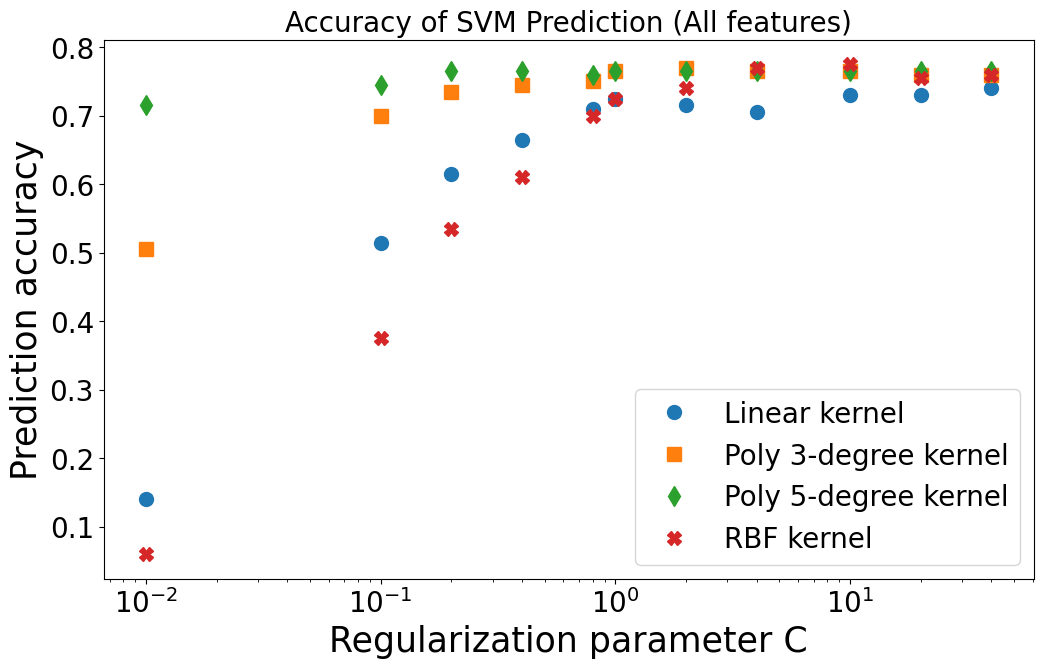

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#This code uses the matplotlib library to create a plot of the accuracy of SVM prediction
#for different regularization parameters and kernel types. 
def plotSVM(Cs, a_linear, a_poly3, a_poly5, a_rbf):
    plt.figure(figsize=(12, 7))
    plt.semilogx(Cs, a_linear, 'o-', markersize=10, linestyle='None', label='Linear kernel')
    plt.semilogx(Cs, a_poly3, 's-', markersize=10, linestyle='None', label='Poly 3-degree kernel')
    plt.semilogx(Cs, a_poly5, 'd-', markersize=10, linestyle='None', label='Poly 5-degree kernel')
    plt.semilogx(Cs, a_rbf, 'X-', markersize=10, linestyle='None', label='RBF kernel')

    plt.title("Accuracy of SVM Prediction (All features)", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("Regularization parameter C", fontsize=25)
    plt.ylabel("Prediction accuracy", fontsize=25)

    plt.legend(bbox_to_anchor=(1.0, 0.0), loc='lower right', fontsize=20)

    # Find the highest accuracy data point
    max_acc_idx = np.argmax(a_linear + a_poly3 + a_poly5 + a_rbf)
    max_acc = max(a_linear + a_poly3 + a_poly5 + a_rbf)
    max_acc_C = Cs[max_acc_idx]

    # Add a text label to the highest accuracy data point
    plt.text(max_acc_C, max_acc, f'{max_acc:.2f}', fontsize=15, ha='center', va='bottom')



plotSVM(Cs, a_linear, a_poly3, a_poly5, a_rbf)

<ipython-input-46-4a0437229910>:30: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(k_values, accuracies[:, i, j], 'o-', markersize=10, linestyle='None', mec='None', label=f"{weight} + {metric}")


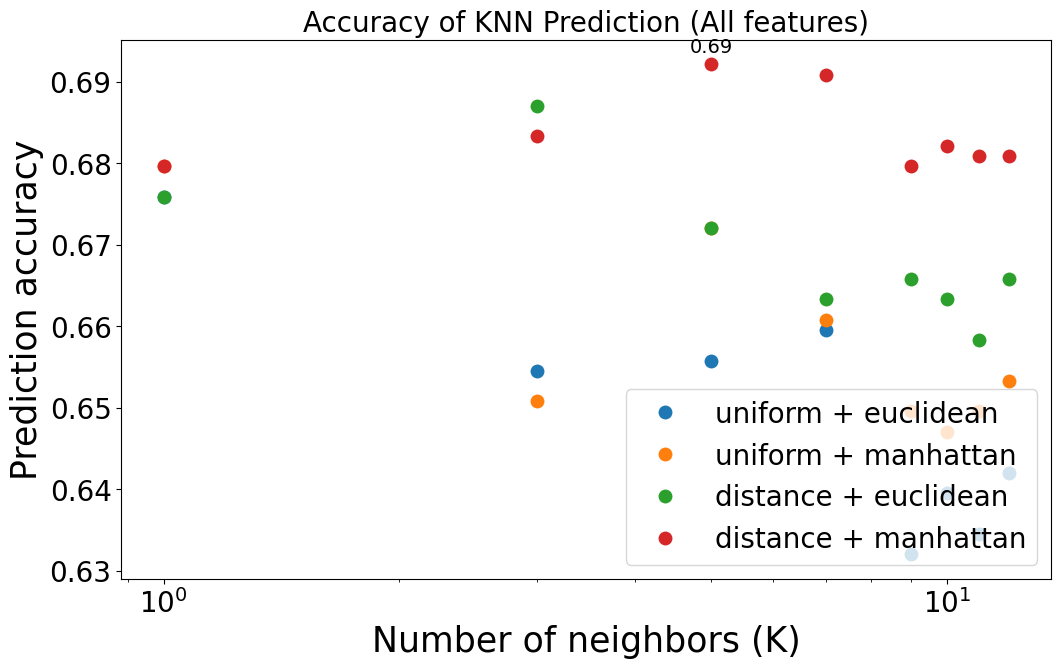

In [ ]:
from sklearn.model_selection import cross_val_score

# Define a range of parameter values to try
k_values = [1, 3, 5, 7, 9, 10, 11, 12]
weights = ['uniform', 'distance']
metrics = ['euclidean', 'manhattan']

# Initialize empty arrays to store accuracy scores
accuracies = np.zeros((len(k_values), len(weights), len(metrics)))

# Loop over parameter values and fit KNN model with each combination
for i, k in enumerate(k_values):
    for j, weight in enumerate(weights):
        for kk, metric in enumerate(metrics):
            knn = KNeighborsClassifier(n_neighbors=k, weights=weight, metric=metric)
            
            # Perform cross-validation with 5 folds and get the average accuracy score
            accuracy_scores = cross_val_score(knn, X_train, y_train, cv=5)
            accuracy = np.mean(accuracy_scores)

            # Store accuracy score for this combination of parameters
            accuracies[i, j, kk] = accuracy


# Plot accuracy for different parameter values
plt.figure(figsize=(12, 7))

for i, weight in enumerate(weights):
    for j, metric in enumerate(metrics):
        plt.semilogx(k_values, accuracies[:, i, j], 'o-', markersize=10, linestyle='None', mec='None', label=f"{weight} + {metric}")

# Add label to the highest datapoint on the Y axis
max_accuracy = np.max(accuracies)
max_k, max_weight_index, max_metric_index = np.unravel_index(np.argmax(accuracies), accuracies.shape)
max_accuracy_index = np.argmax(accuracies[:, max_weight_index, max_metric_index])
plt.text(k_values[max_accuracy_index], max_accuracy+0.001, f"{max_accuracy:.2f}", fontsize=14, ha='center', va='bottom')

plt.title("Accuracy of KNN Prediction (All features)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Number of neighbors (K)", fontsize=25)
plt.ylabel("Prediction accuracy", fontsize=25)

plt.legend(loc='lower right', fontsize=20)
plt.show()


# Random feature selection

In [59]:
# import all the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [60]:
# Load data from csv file
df = pd.read_csv('extracted-features.csv', index_col=0)

In [61]:
# drop the 'file' column
df.drop('file', axis=1, inplace=True)

In [62]:
# seperating the independent and target variables 
X = df.drop('name', axis=1)
y = df['name']

# KNN

In [63]:
num_features = len(df.columns)
num_iterations = 1000  # number of iterations to run
subset_size = 10  # size of each subset to select
best_subset = None
best_accuracy = 0

for i in range(num_iterations):
    # Select a random subset of features
    selected_features = np.random.choice(X.columns, size=subset_size, replace=False)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2)

    # Train KNN model on the training set
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)

    # Evaluate accuracy on the testing set
    knn_acc = accuracy_score(y_test, knn.predict(X_test))

    # Store the best subset and accuracy obtained in this iteration
    if knn_acc > best_accuracy:
        best_accuracy = knn_acc
        best_subset = selected_features
    
    # Print the subset and accuracy obtained in this iteration
    print(f"Iteration {i+1}:")
    print(f"KNN subset: {selected_features}")
    print(f"Accuracy KNN: {knn_acc:.3f}")
    print()

# Print the best subset and accuracy obtained over all iterations
print("Best subset:")
print(best_subset)
print(f"Best accuracy: {best_accuracy:.3f}")


Iteration 1:
KNN subset: ['data38' 'data37' 'data45' 'data46' 'data27' 'data49' 'data34' 'data10'
 'data36' 'data18' 'data3' 'data6' 'data28' 'data31' 'data1']
Accuracy KNN: 0.415

Iteration 2:
KNN subset: ['data10' 'data33' 'data26' 'data22' 'data2' 'data45' 'data20' 'data47'
 'data46' 'data9' 'data41' 'data38' 'data25' 'data58' 'data8']
Accuracy KNN: 0.175

Iteration 3:
KNN subset: ['data13' 'data39' 'data19' 'data45' 'data12' 'data58' 'data25' 'data57'
 'data54' 'data23' 'data55' 'data18' 'data9' 'data37' 'data21']
Accuracy KNN: 0.160

Iteration 4:
KNN subset: ['data33' 'data28' 'data48' 'data45' 'data55' 'data51' 'data37' 'data39'
 'data21' 'data50' 'data2' 'data34' 'data7' 'data43' 'data5']
Accuracy KNN: 0.245

Iteration 5:
KNN subset: ['data7' 'data25' 'data9' 'data52' 'data21' 'data46' 'data23' 'data39'
 'data18' 'data10' 'data1' 'data44' 'data43' 'data48' 'data19']
Accuracy KNN: 0.165

Iteration 6:
KNN subset: ['data48' 'data7' 'data14' 'data2' 'data25' 'data6' 'data58' 'data52

<ipython-input-64-57546e767147>:30: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(k_values, accuracies[:, i, j], 'o-', markersize=10, linestyle='None', mec='None', label=f"{weight} + {metric}")


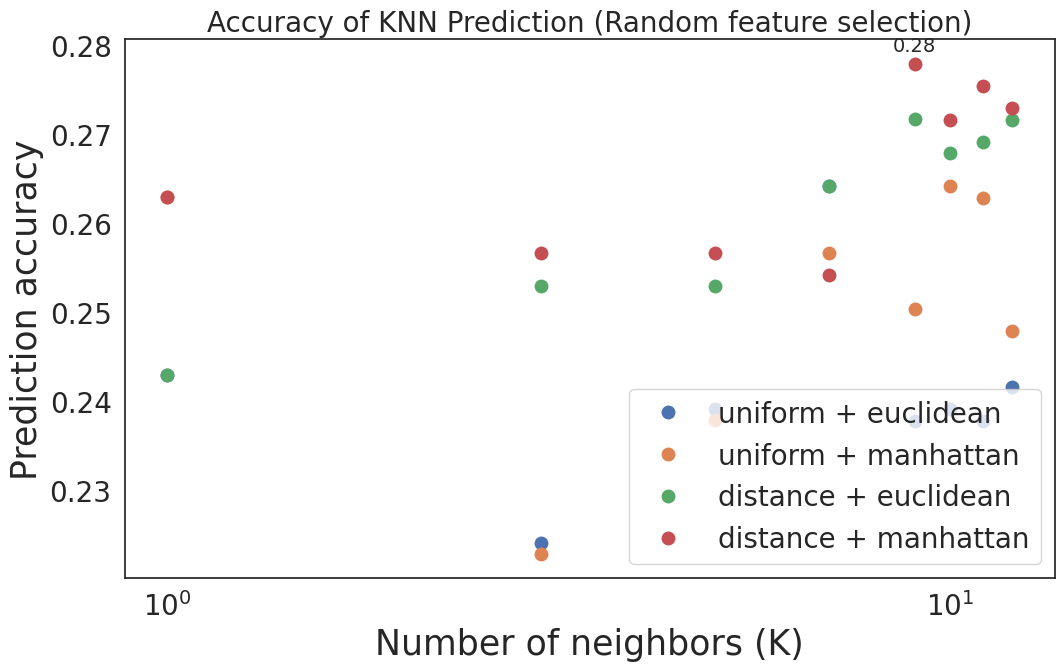

In [64]:
from sklearn.model_selection import cross_val_score

# Define a range of parameter values to try
k_values = [1, 3, 5, 7, 9, 10, 11, 12]
weights = ['uniform', 'distance']
metrics = ['euclidean', 'manhattan']

# Initialize empty arrays to store accuracy scores
accuracies = np.zeros((len(k_values), len(weights), len(metrics)))

# Loop over parameter values and fit KNN model with each combination
for i, k in enumerate(k_values):
    for j, weight in enumerate(weights):
        for kk, metric in enumerate(metrics):
            knn = KNeighborsClassifier(n_neighbors=k, weights=weight, metric=metric)
            
            # Perform cross-validation with 5 folds and get the average accuracy score
            accuracy_scores = cross_val_score(knn, X_train, y_train, cv=5)
            accuracy = np.mean(accuracy_scores)

            # Store accuracy score for this combination of parameters
            accuracies[i, j, kk] = accuracy


# Plot accuracy for different parameter values
plt.figure(figsize=(12, 7))

for i, weight in enumerate(weights):
    for j, metric in enumerate(metrics):
        plt.semilogx(k_values, accuracies[:, i, j], 'o-', markersize=10, linestyle='None', mec='None', label=f"{weight} + {metric}")

# Add label to the highest datapoint on the Y axis
max_accuracy = np.max(accuracies)
max_k, max_weight_index, max_metric_index = np.unravel_index(np.argmax(accuracies), accuracies.shape)
max_accuracy_index = np.argmax(accuracies[:, max_weight_index, max_metric_index])
plt.text(k_values[max_accuracy_index], max_accuracy+0.001, f"{max_accuracy:.2f}", fontsize=14, ha='center', va='bottom')

plt.title("Accuracy of KNN Prediction (Random feature selection)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Number of neighbors (K)", fontsize=25)
plt.ylabel("Prediction accuracy", fontsize=25)

plt.legend(loc='lower right', fontsize=20)
plt.show()


# SVM

In [ ]:
num_features = len(df.columns)
num_iterations = 100  # number of iterations to run
subset_size = 15  # size of each subset to select
best_subset = None
best_accuracy = 0

for i in range(num_iterations):
    # Select a random subset of features
    selected_features = np.random.choice(X.columns, size=subset_size, replace=False)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2)

    # Train SVC model on the training set
    svc = SVC()
    svc.fit(X_train, y_train)

    # Evaluate accuracy on the testing set
    svc_acc = accuracy_score(y_test, svc.predict(X_test))

    # Store the best subset and accuracy obtained in this iteration
    if svc_acc > best_accuracy:
        best_accuracy = svc_acc
        best_subset = selected_features
    
    # Print the subset and accuracy obtained in this iteration
    print(f"Iteration {i+1}:")
    print(f"SVC subset: {selected_features}")
    print(f"Accuracy SVC: {svc_acc:.3f}")
    print()

# Print the best subset and accuracy obtained over all iterations
print("Best subset:")
print(best_subset)
print(f"Best accuracy: {best_accuracy:.3f}")


Iteration 1:
SVC subset: ['data24' 'data12' 'data38' 'data16' 'data32' 'data56' 'data48' 'data2'
 'data49' 'data54' 'data13' 'data17' 'data36' 'data30' 'data5']
Accuracy SVC: 0.195

Iteration 2:
SVC subset: ['data35' 'data22' 'data43' 'data7' 'data6' 'data56' 'data45' 'data44'
 'data23' 'data30' 'data26' 'data14' 'data36' 'data28' 'data11']
Accuracy SVC: 0.215

Iteration 3:
SVC subset: ['data51' 'data39' 'data12' 'data56' 'data32' 'data45' 'data30' 'data25'
 'data44' 'data42' 'data48' 'data57' 'data5' 'data19' 'data38']
Accuracy SVC: 0.210

Iteration 4:
SVC subset: ['data41' 'data17' 'data16' 'data52' 'data5' 'data46' 'data11' 'data19'
 'data12' 'data22' 'data42' 'data48' 'data36' 'data2' 'data32']
Accuracy SVC: 0.275

Iteration 5:
SVC subset: ['data3' 'data6' 'data14' 'data26' 'data4' 'data13' 'data21' 'data10'
 'data39' 'data37' 'data53' 'data35' 'data25' 'data8' 'data11']
Accuracy SVC: 0.215

Iteration 6:
SVC subset: ['data43' 'data13' 'data9' 'data29' 'data26' 'data44' 'data49' 'da

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score

#modelTest that takes a machine learning model as input,
#fits the model to the training data and then uses the trained model
#to make predictions on the test data. The function then calculates and
#returns the accuracy score

# Split the data into training and testing sets using the best subset of features
X_train, X_test, y_train, y_test = train_test_split(df[best_subset], y, test_size=0.2)

def modelTest(model):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

#This code defines a grid search using a combination of hyperparameters for a support vector machine
# (SVM) model. The hyperparameters being explored include the regularization parameter C,
#the kernel function (linear, poly, or rbf), the degree of the polynomial kernel
#(for poly kernel only), and whether to use probability estimates. 

Cs = [0.01,0.1,0.2,0.4,0.8,1,2,4,10,20,40]
kernels = ['linear', 'poly', 'poly', 'rbf']
degrees = [3, 3, 5, 3]
a_results = [[], [], [], []]


for i, cc in enumerate(Cs):
    print('C=' + str(cc))
    for j in range(4):
        svm = SVC(kernel=kernels[j], degree=degrees[j], gamma='scale', shrinking=True, C=cc, probability=True, decision_function_shape="ovo")
        a = modelTest(svm)
        a_results[j].append(a)
        
a_linear, a_poly3, a_poly5, a_rbf = a_results

C=0.01
C=0.1
C=0.2
C=0.4
C=0.8
C=1
C=2
C=4
C=10
C=20
C=40


<ipython-input-16-9e6436285521>:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(Cs, a_linear, 'o-', markersize=10, linestyle='None', label='Linear kernel')
<ipython-input-16-9e6436285521>:9: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(Cs, a_poly3, 's-', markersize=10, linestyle='None', label='Poly 3-degree kernel')
<ipython-input-16-9e6436285521>:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "d-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.semilogx(Cs, a_poly5, 'd-', markersize=10, linestyle='None', label='Poly 5-degree kernel')
<ipython-input-16-9e6436285521>:11: UserWarning: linestyle is redundantly defined by the 'linestyle' k

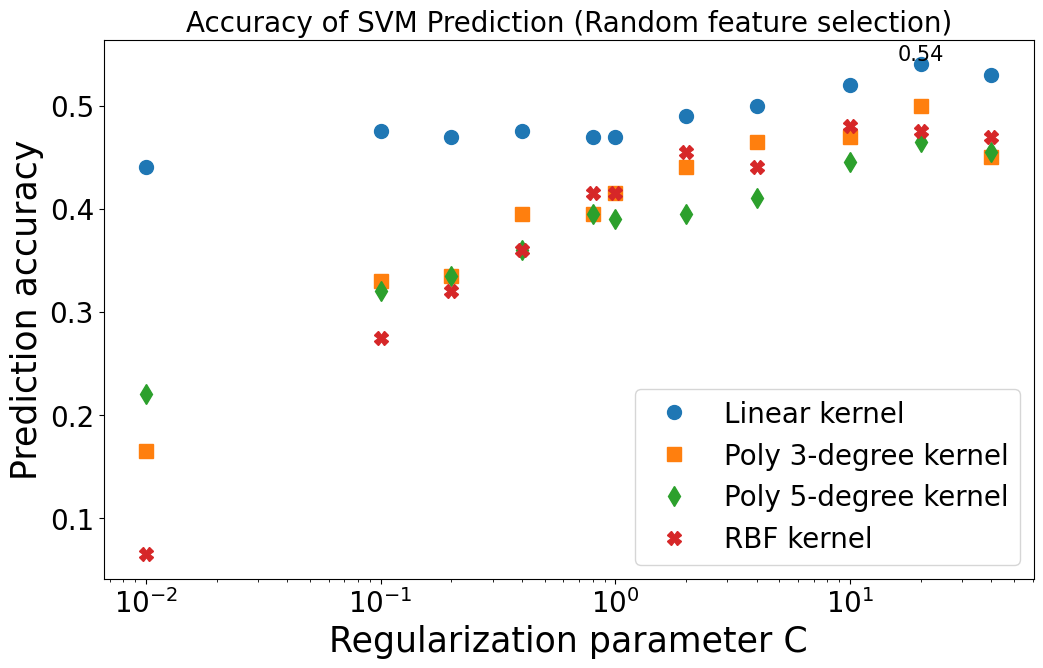

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#This code uses the matplotlib library to create a plot of the accuracy of SVM prediction
#for different regularization parameters and kernel types. 
def plotSVM(a_linear, a_poly3, a_poly5, a_rbf):
    plt.figure(figsize=(12, 7))
    plt.semilogx(Cs, a_linear, 'o-', markersize=10, linestyle='None', label='Linear kernel')
    plt.semilogx(Cs, a_poly3, 's-', markersize=10, linestyle='None', label='Poly 3-degree kernel')
    plt.semilogx(Cs, a_poly5, 'd-', markersize=10, linestyle='None', label='Poly 5-degree kernel')
    plt.semilogx(Cs, a_rbf, 'X-', markersize=10, linestyle='None', label='RBF kernel')

    plt.title("Accuracy of SVM Prediction (Random feature selection)", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("Regularization parameter C", fontsize=25)
    plt.ylabel("Prediction accuracy", fontsize=25)

    plt.legend(bbox_to_anchor=(1.0, 0.0), loc='lower right', fontsize=20)

    max_acc_idx = np.argmax(a_linear + a_poly3 + a_poly5 + a_rbf)
    max_acc = max(a_linear + a_poly3 + a_poly5 + a_rbf)
    max_acc_C = Cs[max_acc_idx]

    plt.text(max_acc_C, max_acc, f'{max_acc:.2f}', fontsize=15, ha='center', va='bottom')

plotSVM(a_linear, a_poly3, a_poly5, a_rbf)